In [97]:
# imports
import pandas as pd
import seaborn as sns
import glob
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [98]:
# configurate general settings
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [99]:
# get all required file paths 
tmdb_files = sorted(glob.glob("Data/final_tmdb_data_201*.csv.gz"))
# load and combine data in a single dataframe
df_movies = pd.concat([pd.read_csv(f) for f in tmdb_files])

In [100]:
# display the two first rows
df_movies.head(2)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/lqUbt2cy2pnqvxKefbQAtxLS0WA.jpg,NaN,0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738,tt0312305,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",3.788,/uneDCn8y6RHKc5IAfpgznmaan9I.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-09-17,0,45,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,False,7.182,11,NaN
1,False,/aHspMnRBCdJwgHwQCvARQGWXuxS.jpg,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048,tt0326965,en,In My Sleep,"A sleepwalking, sexaholic masseur wakes up, co...",2.286,/x1GJBX0RPkYuA77WujLyyLAoDAn.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0,90,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking can be deadly.,In My Sleep,False,5.300,34,PG-13


In [101]:
# columns types
df_movies.dtypes

adult                       bool
backdrop_path             object
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                    int64
runtime                    int64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                       bool
vote_average             float64
vote_count                 int64
certification             object
dtype: object

In [102]:
# create a dictionary for certifications
mpaa_ratings = ["G", "PG", "PG-13", "R"]
groups = {}
for cer in mpaa_ratings:
    data = df_movies.loc[df_movies["certification"]==cer, "revenue"].copy()
    groups[cer] = data

In [103]:
# check normality for each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                             'p-value':p,
                             'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p-value,test stat
G,252.0,1.219315e-74,340.386016
PG,767.0,2.415887e-140,642.959693
PG-13,1581.0,0.000000e+00,1597.103955
R,2805.0,0.000000e+00,3615.320483


The normality test p-values for each group are below 0.05 which means that the data in each group is not normally distributed, but the samples sizes are large enough to proceed without satisfying this test.

In [104]:
# check homoscedasticity
stats.levene(*groups.values())

LeveneResult(statistic=74.47818316677962, pvalue=3.374720509403088e-47)

the homoscedasticity test p-value is below 0.05 which means that the groups come from pompulations with different variances. To deal with this we will use Kruskal-Wallis test wich don't assume homoscedasticity

In [105]:
result = stats.kruskal( *groups.values())
result

KruskalResult(statistic=170.11607523181857, pvalue=1.2011774011778931e-36)

The p-value is equal to 1.2011774011778931e-36 which is significant as it is below 0.05, so we can reject the null hypothesis and accept the alternative one which states that the average revenues change with certifications.

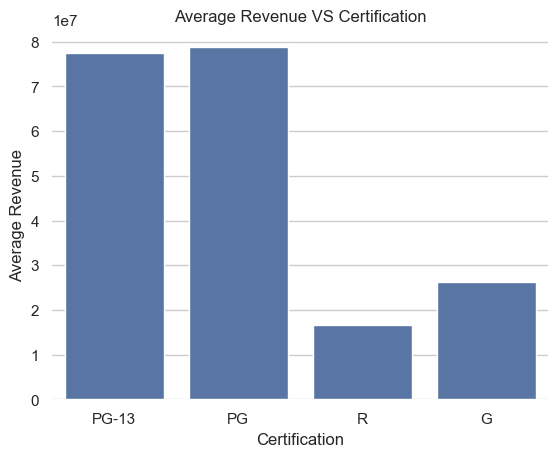

In [106]:
# compare the groups means
mpaa_ratings_df = df_movies[df_movies.certification.isin(mpaa_ratings)]
ax = sns.barplot(x=mpaa_ratings_df.certification, y=mpaa_ratings_df.revenue,
                 errorbar=None)
ax.set(xlabel="Certification")
ax.set_ylabel("Average Revenue")
ax.set_title("Average Revenue VS Certification")
sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)

We see that PG certification has the highest average revenue.

In [107]:
# separate data into movies that last more than 1.5 hours and movies that last equal or less than 1.5 hours
over_90_df = df_movies[df_movies.runtime>90].copy()
under_90_df = df_movies[df_movies.runtime<=90].copy()

In [108]:
# define revenues in each group
over_90_revenue = over_90_df.revenue
under_90_revenue = under_90_df.revenue

In [109]:
# check for outliers
over_90_zscores= stats.zscore(over_90_revenue)
over_90_outliers = abs(over_90_zscores)>3
under_90_zscores= stats.zscore(under_90_revenue)
under_90_outliers = abs(under_90_zscores)>3
print(f'"over 90" group: {over_90_outliers.sum()}\n"under 90" group: {under_90_outliers.sum()}')

"over 90" group: 286
"under 90" group: 83


In [110]:
# remove outliers in each group
over_90_revenue = over_90_revenue[abs(stats.zscore(over_90_revenue))<=3]
under_90_revenue = under_90_revenue[abs(stats.zscore(under_90_revenue))<=3]

In [111]:
# groups sizes
print(f'"over 90" group: {len(over_90_revenue)}\n"under 90" group: {len(under_90_revenue)}')

"over 90" group: 20104
"under 90" group: 16324


In [112]:
# check for normality
nor_result_over_90 = stats.normaltest(over_90_revenue)
nor_result_under_90 = stats.normaltest(under_90_revenue)
print(f'"over 90" group: {nor_result_over_90}\n"under 90" group: {nor_result_under_90}')

"over 90" group: NormaltestResult(statistic=23669.254769602714, pvalue=0.0)
"under 90" group: NormaltestResult(statistic=31467.662557123702, pvalue=0.0)


The normality test p-values for each group are below 0.05 which means that the data in each group is not normally distributed, but the samples sizes are large enough to proceed without satisfying this test.

In [113]:
# check for equal variance
result_var = stats.levene(over_90_revenue, under_90_revenue)
result_var

LeveneResult(statistic=692.4825588377435, pvalue=3.357244887975426e-151)

The homoscedasticity test p-value is below 0.05 which means that the samples come from populations with different variances, so we will use a t-test that assume different variances.


In [114]:
# perform an independent one tailed t-test
t_test_result = stats.ttest_ind(over_90_revenue, under_90_revenue, alternative="greater", equal_var=False)
t_test_result

TtestResult(statistic=29.14827968903374, pvalue=2.3063420142911105e-183, df=20552.425397790455)

The p-value for the t-test is below 0.05, so we can reject the null hypothesis and accept the alternative one which states that movies that last over 1.5 hours earn more revenue than movies that last under or equal to 1.5 hours.

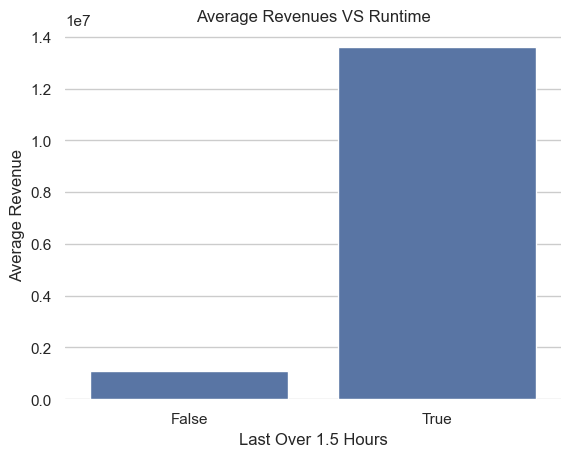

In [115]:
# compare groups means
df_movies["last_over_1.5_hours"] = df_movies.runtime>90
ax = sns.barplot(x=df_movies["last_over_1.5_hours"], y=df_movies.revenue, errorbar=None)
ax.set(xlabel="Last Over 1.5 Hours")
ax.set_ylabel("Average Revenue")
ax.set_title("Average Revenues VS Runtime")
sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)

In [116]:
# separate data into 2010 and 2018 movies
df_movies.release_date = pd.to_datetime(df_movies.release_date)
movies_2010_df = df_movies[df_movies.release_date.dt.year==2010].copy()
movies_2019_df = df_movies[df_movies.release_date.dt.year==2018].copy()

In [117]:
# define revenues in each group
revenues_2010 = movies_2010_df.revenue
revenues_2018 = movies_2018_df.revenue

In [118]:
# check for outliers
revenues_2010_zscores= stats.zscore(revenues_2010)
revenues_2010_outliers = abs(revenues_2010_zscores)>3
revenues_2018_zscores= stats.zscore(revenues_2018)
revenues_2018_outliers = abs(revenues_2018_zscores)>3
print(f'"2010 movies" group: {revenues_2010_outliers.sum()}\n"2018 movies" group: {revenues_2018_outliers.sum()}')

"2010 movies" group: 39
"2018 movies" group: 41


In [119]:
# remove outliers in each group
revenues_2010 = revenues_2010[abs(stats.zscore(revenues_2010))<=3]
revenues_2018 = revenues_2018[abs(stats.zscore(revenues_2018))<=3]

In [120]:
# groups sizes
print(f'"has discount" group: {len(revenues_2010)}\n"no discount" group: {len(revenues_2018)}')

"has discount" group: 2356
"no discount" group: 4375


In [121]:
# check for normality
nor_result_revenues_2010 = stats.normaltest(revenues_2010)
nor_result_revenues_2018 = stats.normaltest(revenues_2018)
print(f'"2010 movies" group: {nor_result_revenues_2010}\n"2018 movies" group: {nor_result_revenues_2018}')

"2010 movies" group: NormaltestResult(statistic=2733.6675724599413, pvalue=0.0)
"2018 movies" group: NormaltestResult(statistic=6239.930858621606, pvalue=0.0)


The normality test p-values for each group are below 0.05 which means that the data in each group is not normally distributed, but the samples sizes are large enough to proceed without satisfying this test.

In [122]:
# check for equal variance
result_var = stats.levene(revenues_2010, revenues_2018)
result_var

LeveneResult(statistic=21.548587431665755, pvalue=3.515188306323848e-06)

The homoscedasticity test p-value is below 0.05 which means that the samples come from populations with different variances, so we will use a t-test that assume different variances.


In [123]:
# perform an independent one tailed t-test
t_test_result = stats.ttest_ind(revenues_2010, revenues_2018, alternative="greater", equal_var=False)
t_test_result

TtestResult(statistic=4.2130435618018485, pvalue=1.2899383505585547e-05, df=3683.512003139902)

The p-value for the t-test is below 0.05, so we can reject the null hypothesis and accept the alternative one which sates that movies released in 2010 earn more revenue than movies released in 2018

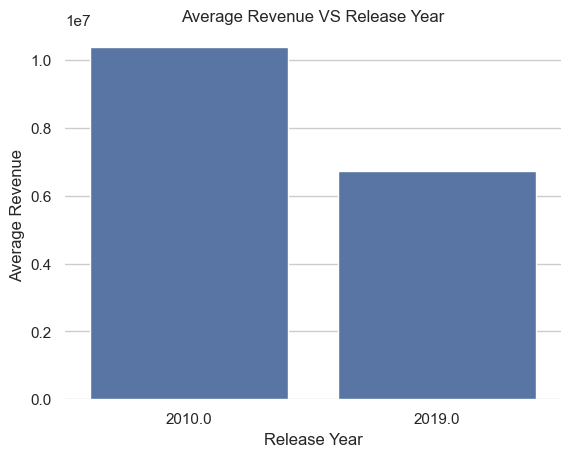

In [125]:
# compare groups means
df_movies["release_year"] = df_movies.release_date.dt.year
df_2010_2019 = df_movies[df_movies.release_year.isin([2010, 2019])]
ax = sns.barplot(x=df_2010_2019.release_year, y=df_2010_2019.revenue, errorbar=None)
ax.set(xlabel="Release Year")
ax.set_ylabel("Average Revenue")
ax.set_title("Average Revenue VS Release Year")
sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)